This document is the first time that i tried to create a method which changed the lookback. This was an extra add on to the ACI method and as a result it did not interfere with the online update of alpha.

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [ ]:
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [84]:
def scale_C_t(scale, alpha_t, scores, sigma_t, t, interval=50):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[t-interval:t], 1 - alpha_t)
    positve_v = (sigma_t) + scale *(abs(sigma_t) * Q)
    negative_v = (sigma_t) - scale *(abs(sigma_t) * Q)
    return negative_v, positve_v

def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1

def scaled_ACI(coverage_target: float, timeseries_data: tuple, gamma: float, custom_interval: int) -> dict:
    xpred, y = timeseries_data
    alpha_t_list = [coverage_target]

    All_scores = (abs(y - xpred))/abs(xpred)

    err_t_list = []
    conformal_sets_list = []
    
    error_counter = 0
    for i in range(custom_interval+1, len(All_scores)):
        # Look back window
        look_back = min(max(3, custom_interval - 2*error_counter), i)
        scale = 1 + (custom_interval - look_back)/custom_interval

        Coverage_t = scale_C_t(scale, alpha_t_list[-1], All_scores, xpred[i], i, look_back)
        conformal_sets_list.append(Coverage_t)

        error_t = err_t(y[i], Coverage_t)
        err_t_list.append(error_t)

        alpha_t = min(max(alpha_t_list[-1] + (gamma * (coverage_target - error_t)), 0), 1)
        alpha_t_list.append(alpha_t)

        if error_t:
                error_counter+=1
        else:
            error_counter = max(0, error_counter-1)

        

    # Calculating different averages
    realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(custom_interval).mean().mean()
    average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

    return {
        'model': 'scaled_ACI',
        'coverage_target': coverage_target,
        'gamma': gamma,
        'realised_interval_coverage': realised_interval_coverage,
        'alpha_t_list': alpha_t_list,
        'average_prediction_interval': average_prediction_interval,
        'conformal_sets': conformal_sets_list,
        'error_t_list': err_t_list, 
        'interval_size': custom_interval
    }

In [85]:
from ConformalMethods import ACP_data
dataloader = ACP_data(100, 600, dist_shifts=[(-1, 5), (5, 5), (5, 10), (20, 20), (30, 30)])
all_data = dataloader.generate()

scaled 44.82073551420377 non-adaptive 48.34197044328806


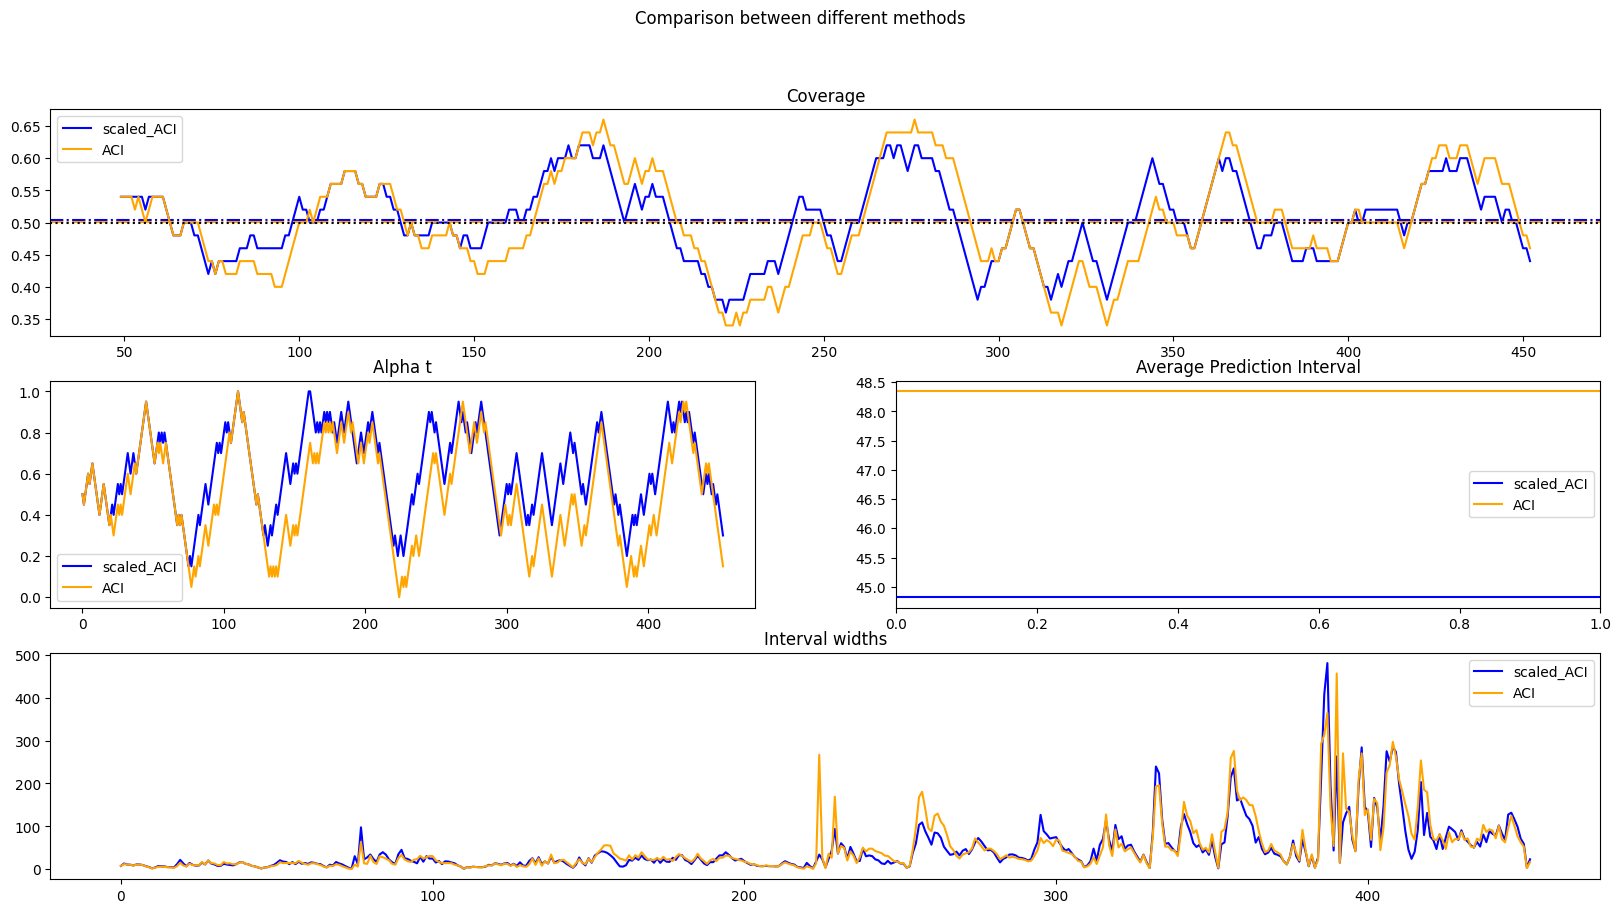

scaled 51.81834650842866 non-adaptive 54.848664694799794


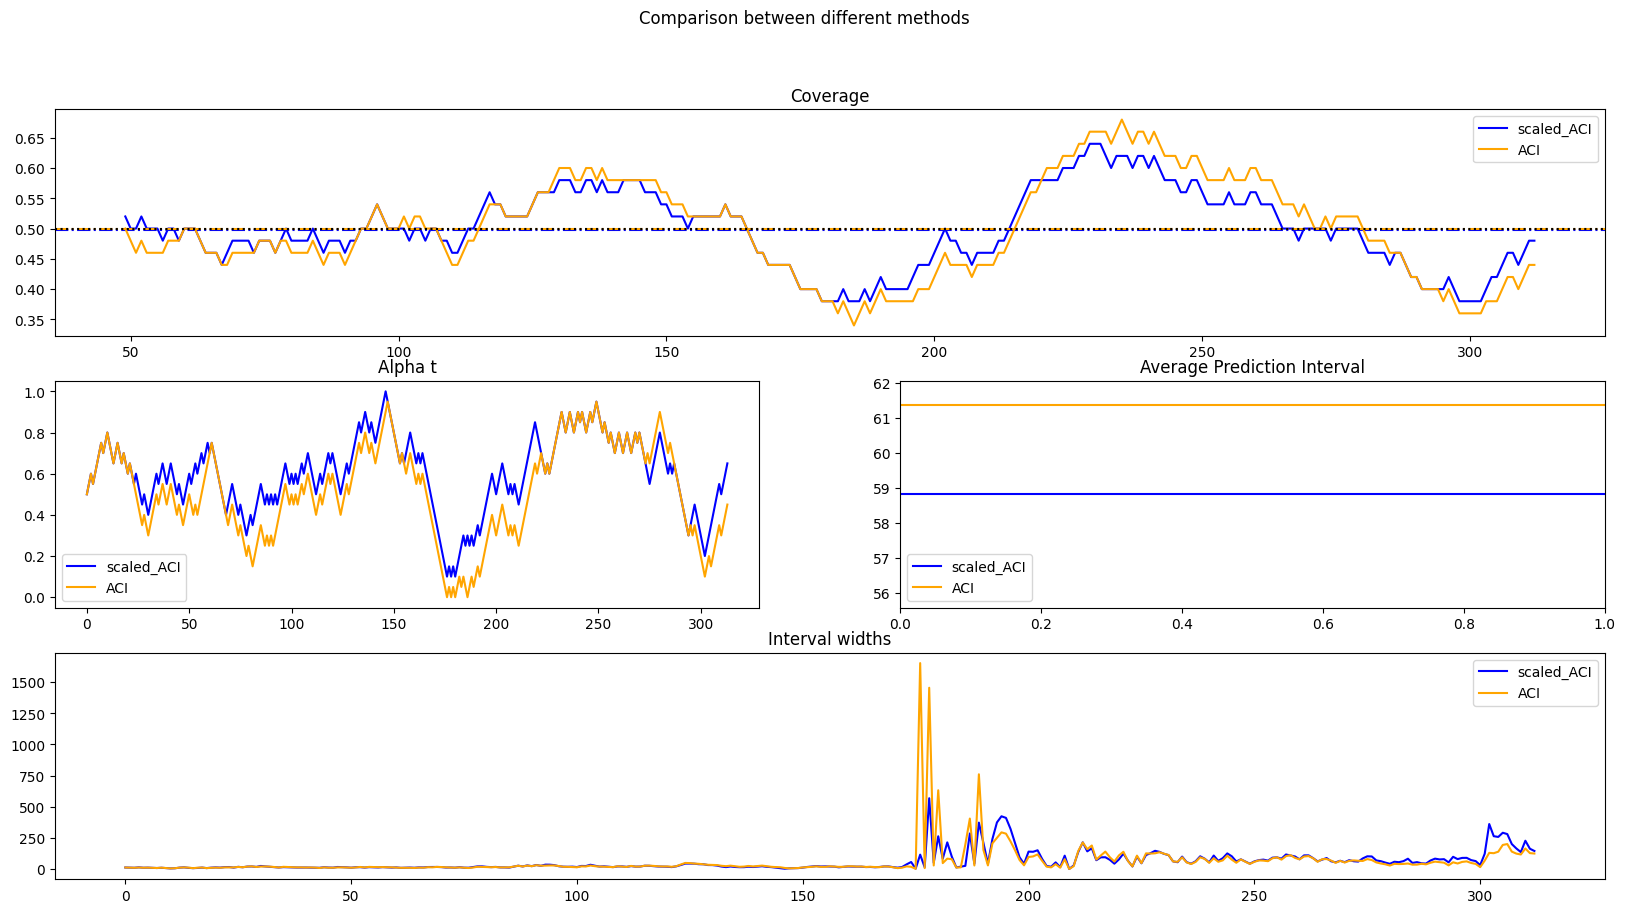

scaled 49.85905576162528 non-adaptive 51.34204723679361


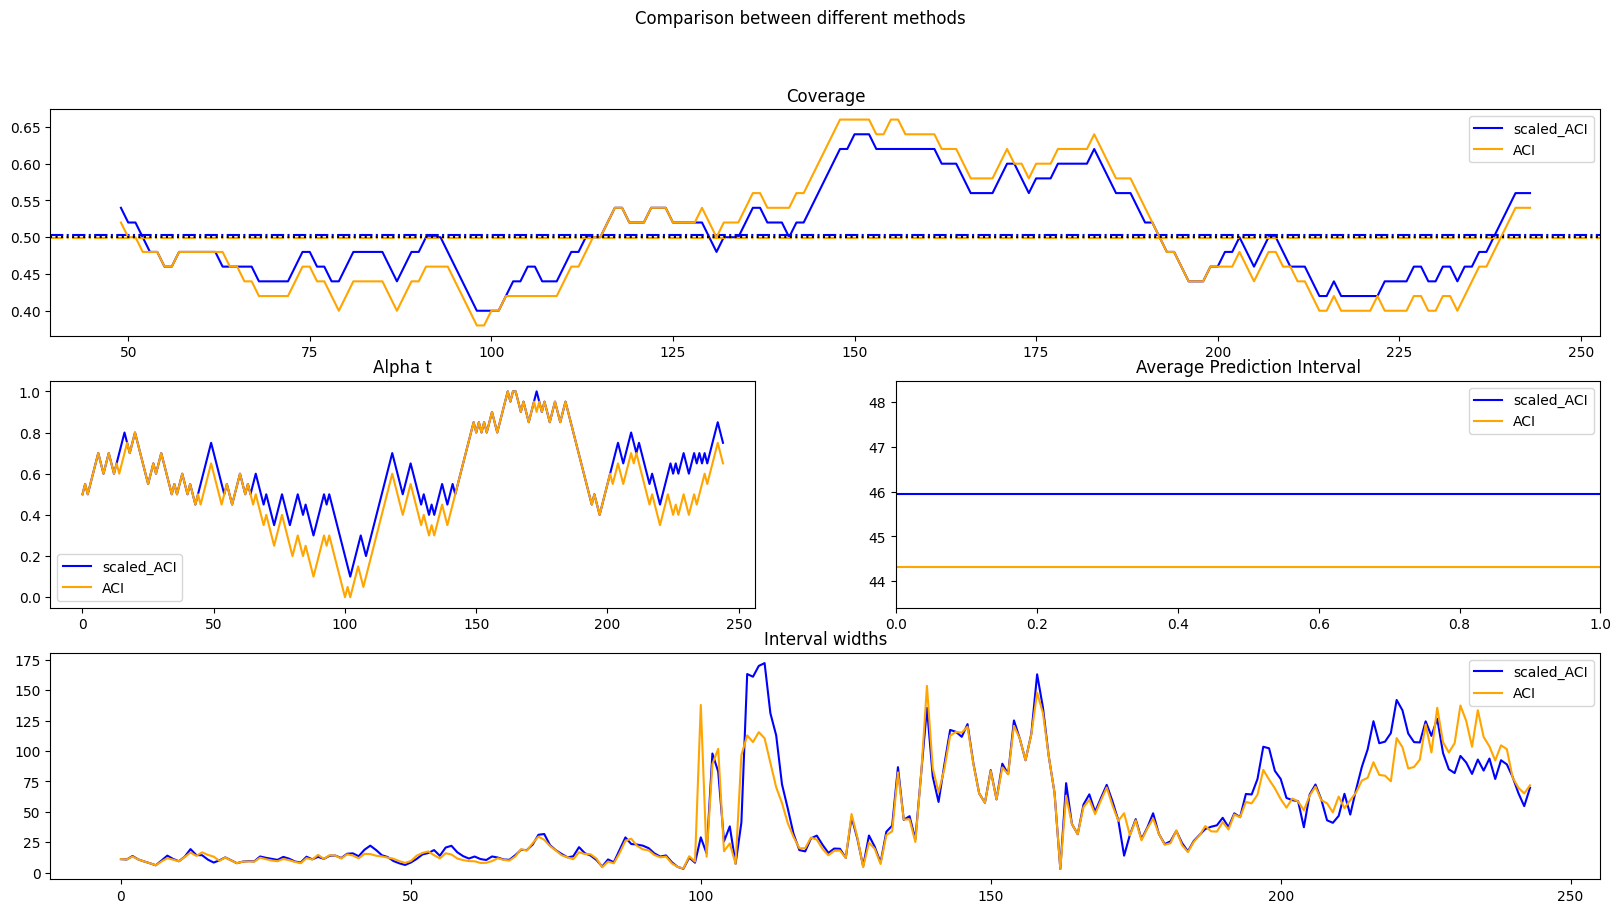

scaled 48.87679292086457 non-adaptive 52.956215152691314


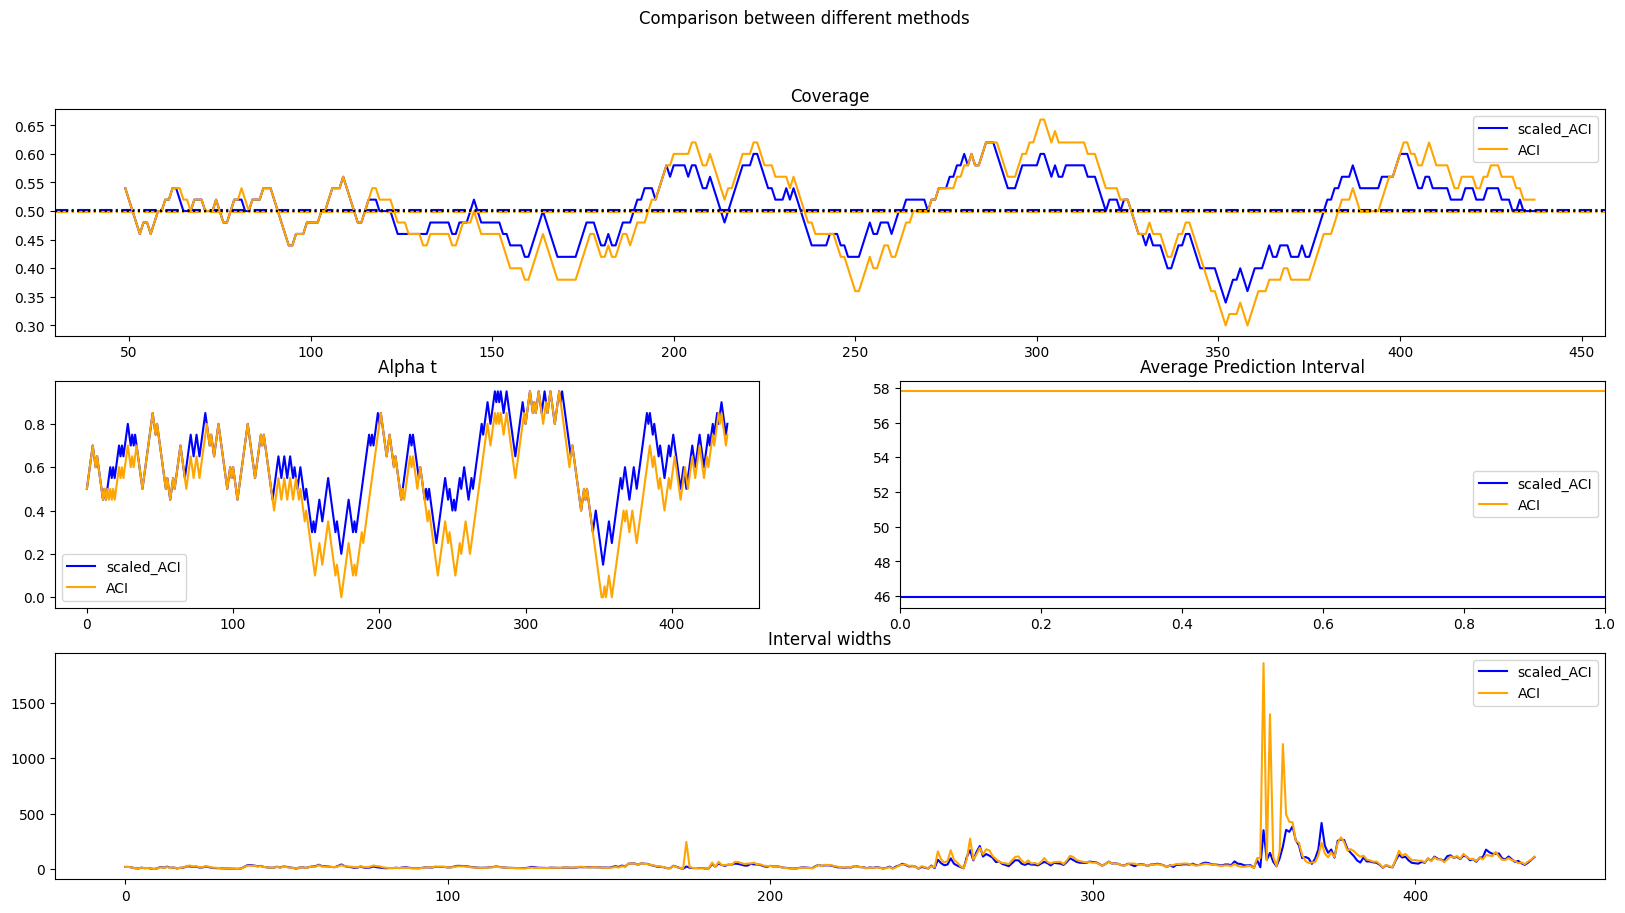

scaled 48.72246842117195 non-adaptive 51.619059221180464


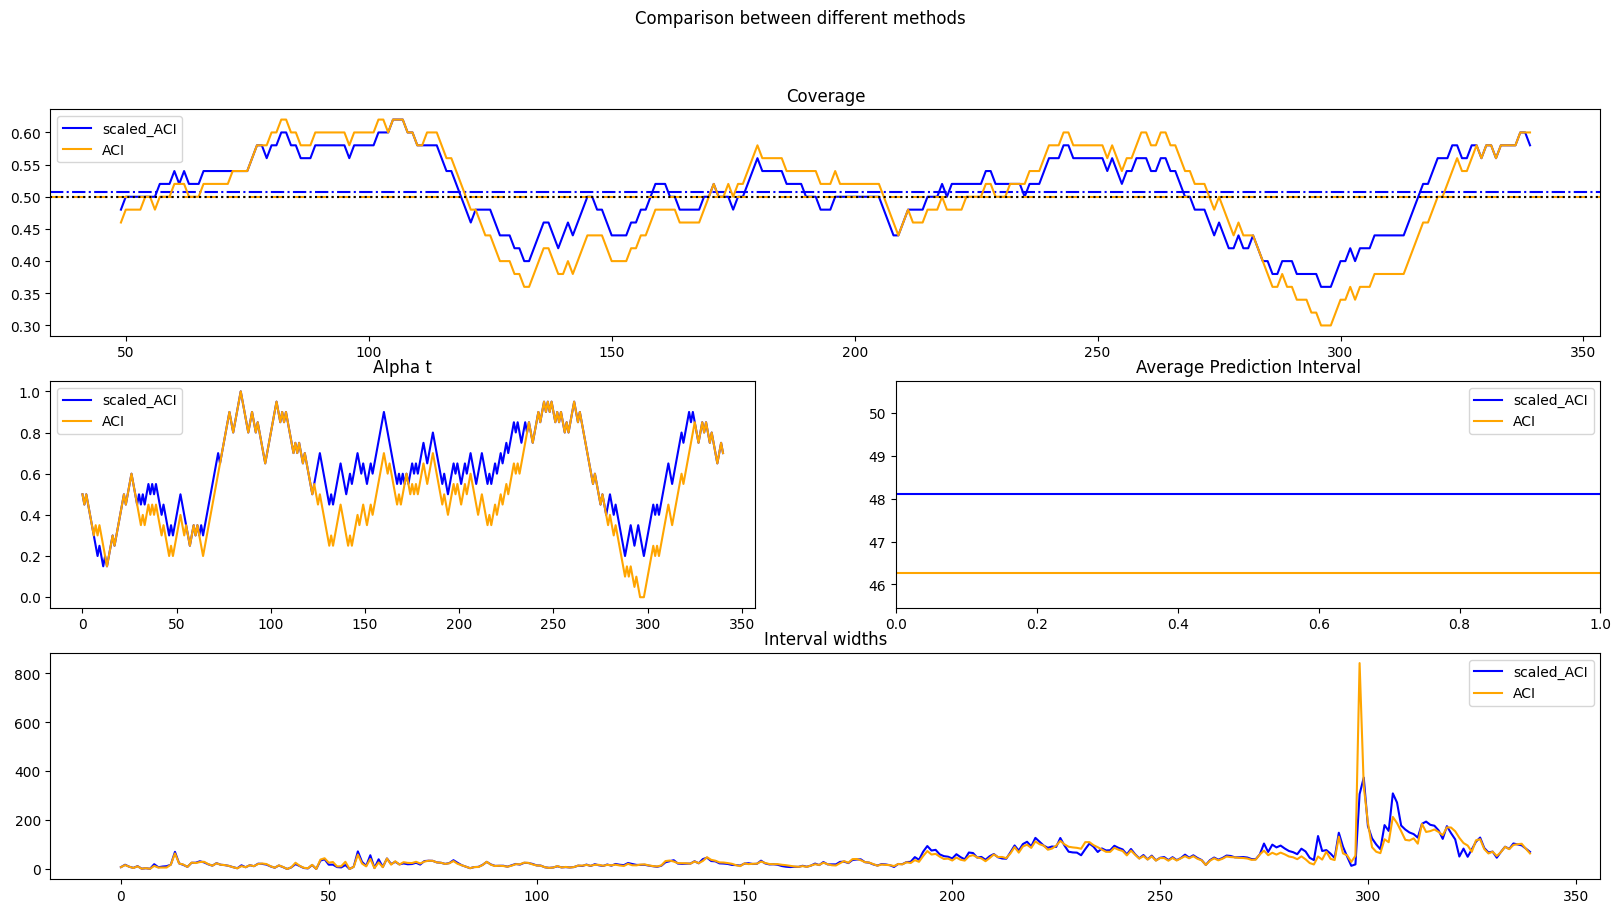

scaled 48.17123445382712 non-adaptive 50.50541317529556
scaled 48.868135820847485 non-adaptive 50.60708474010173
scaled 49.05052966301457 non-adaptive 50.051644794391564
scaled 49.375747160883265 non-adaptive 50.513026894811446
scaled 50.66677892772852 non-adaptive 58.55438268742105
scaled 50.735562611786094 non-adaptive 58.040760541634725
scaled 49.994692442374294 non-adaptive 56.65823101687251
scaled 49.57151063670601 non-adaptive 58.39232355429279
scaled 48.82975556525052 non-adaptive 57.10877201079542
scaled 48.33367404457767 non-adaptive 56.024119484589455
scaled 47.98403588426428 non-adaptive 55.114455107826444
scaled 48.52588437108491 non-adaptive 55.19011553812908
scaled 48.36480374283584 non-adaptive 54.695424949494
scaled 48.03945919036946 non-adaptive 54.17477210136947
scaled 48.39104350485885 non-adaptive 54.30627121688584
scaled 48.34892066196835 non-adaptive 54.00781251423899
scaled 48.27963569087479 non-adaptive 53.44230442852376
scaled 47.87926295089088 non-adaptive 53.

In [86]:
from ConformalMethods import ACP_plots
from ConformalMethods import AdaptiveCP

ACP = AdaptiveCP(0.5)

records = [[], []]
for i, data in enumerate(all_data):
    scaled = scaled_ACI(0.5, data, 0.1, 50)
    non_adaptive = ACP.ACI(data, 0.1)
    records[0].append(scaled['average_prediction_interval'])
    records[1].append(non_adaptive['average_prediction_interval'])
    print('scaled', np.mean(records[0]), 'non-adaptive', np.mean(records[1]))

    if i <5:
        ACP_plots.compare_many([scaled, non_adaptive])

We observe that this performs better than non adaptive when is good when the data is getting larger and larger, but the current implementation cant deal with when over covering.

In [87]:
from ConformalMethods import ACP_data
second_dataloader = ACP_data(100, 600, dist_shifts=[(30, 30), (20, 20), (10, 10), (0, 5)])
second_data = second_dataloader.generate()

In [91]:
av = []
for i, data in enumerate(second_data):
    dt = ACP.DtACI(data)
    av.append(dt['average_prediction_interval'])
    print('dt', np.mean(av))

dt 49.721938903293804
dt 46.95736588615773
dt 43.13971775997603
dt 69.34537027196967
dt 64.41075115180735
dt 61.25269158078103
dt 60.427213549711105
dt 58.30487851805991
dt 57.00385871834658
dt 55.53624631015591
dt 54.22762587767563
dt 54.06607650814834
dt 53.54819394205641
dt 51.93699629279839
dt 51.31365360971003
dt 50.39557557507907
dt 49.86927128692236
dt 49.46335000904769
dt 49.55327255015791
dt 49.06176601582921
dt 48.614247976396385
dt 48.41291962516554
dt 48.35640249820904
dt 47.979120932629904
dt 47.68190855510315
dt 47.863863024615405
dt 47.435510219182916
dt 47.14536597204967
dt 47.2840715716849
dt 47.79209547837254
dt 47.616513509473315
dt 47.305436991240036
dt 47.199200702745046
dt 47.18073975432606
dt 46.963335001255054
dt 48.01527149459511
dt 47.48920935671224
dt 48.079167661086935
dt 49.14568986510714
dt 166.65765737562432
dt 163.84044630331078
dt 161.4515249751133
dt 158.701088918582
dt 156.03879034652022
dt 155.5257536387989
dt 153.05009591416123
dt 151.58199805504367

In [ ]:
from ConformalMethods import ACP_data
dataloader = ACP_data(5, 600)
all_data = dataloader.generate()

In [90]:
records2 = [[], []]
for i, data in enumerate(second_data):
    scaled = scaled_ACI(0.3, data, 0.1, 50)
    non_adaptive = ACP.ACI(data, 0.1)
    records2[0].append(scaled['average_prediction_interval'])
    records2[1].append(non_adaptive['average_prediction_interval'])
    print('scaled', np.mean(records2[0]), 'ACI', np.mean(records2[1]))
    
    

scaled 73.98963465127005 ACI 46.280642993624234
scaled 68.07942465529342 ACI 44.82566547134927
scaled 62.97796263227226 ACI 41.54494998740984
scaled 65.02124025255893 ACI 41.55132903795148
scaled 64.52589966072358 ACI 41.451060983736134
scaled 64.24620007374084 ACI 40.45260463153639
scaled 66.80879454277593 ACI 41.21150283629161
scaled 65.681050195935 ACI 41.25550667916903
scaled 65.781088667443 ACI 41.54844810989167
scaled 65.9105674363166 ACI 41.48791003816214
scaled 65.824999671945 ACI 41.199796790457405
scaled 66.14343227330151 ACI 41.56490951399011
scaled 65.78276721220064 ACI 41.63464686290693
scaled 64.55159962652087 ACI 41.12037596600298
scaled 65.07310184246562 ACI 41.09746641691541
scaled 64.15912594434668 ACI 40.704357294357806
scaled 63.615084662473116 ACI 40.73840777422742
scaled 64.36259191875143 ACI 40.524429179827045
scaled 65.34025415307153 ACI 40.89737371903842
scaled 64.8379573652906 ACI 40.70623114949325
scaled 64.55498576228595 ACI 40.59603907943084
scaled 64.26265

It does seem to be performing worse. On the data which is getting smaller. It is occasionaly well below suggesting that it is more robust.